In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
from collections import defaultdict

import os
import _ParlayANNpy as pann
import numpy as np
import wrapper as wp
from scipy.sparse import csr_matrix
from tqdm import tqdm

In [11]:
FERN_DATA_DIR = "/ssd1/anndata/bigann/data/"
AWARE_DATA_DIR = "/ssd1/data/bigann/data/"

DATA_DIR = FERN_DATA_DIR
POINTS_PATH = DATA_DIR + "yfcc100M/base.10M.u8bin.crop_nb_10000000"
FILTER_PATH = DATA_DIR + 'yfcc100M/base.metadata.10M.spmat'

In [3]:
ds_constructor = wp.init_filtered_dataset('Euclidian', 'uint8')
ds = ds_constructor(POINTS_PATH, FILTER_PATH)

Detected 10000000 points with dimension 192


In [4]:
ds.distance(244, 897) # distance between two points

163834.0

In [5]:
(ds.size(), ds.get_n_filters()) # (number of points in the dataset, number of filters in the dataset)

(10000000, 200386)

In [6]:
(ds.get_filter_size(0), ds.get_point_size(0)) # (number of points associated with the first filter, number of filters associated with the first point) 
# these are kinda useless idk why I added them

(97939, 13)

In [7]:
ds.get_filter_points(87983) # numpy array of points with label 87983

array([  58816,  113064,  188955,  370216,  434003,  434004,  469554,
        920850, 1254536, 1360330, 1774795, 2083236, 2266041, 2321204,
       2416130, 2427195, 2595615, 2595920, 2595921, 2695724, 2794821,
       2794822, 2796437, 3008463, 3008464, 3365302, 3766123, 3899782,
       3988855, 4309074, 4597811, 4650614, 5045215, 5153757, 5198273,
       5268804, 5268805, 5268806, 5300685, 5386043, 5425117, 5597575,
       5634004, 5658301, 5726002, 5789477, 5820154], dtype=int32)

In [8]:
ds.get_point_filters(244) # numpy array of filters for point 244

array([    3,    21,    23,   762,  1228,  1460,  3295,  6299, 10176,
       10177, 10178], dtype=int32)

In [9]:
ds.get_filter_intersection(2, 244) # numpy array of points that have both label 2 and 244

array([4205554, 4651584, 6189153, 6321122, 6455802, 6519911, 6733346,
       6758710, 6833602, 7076657, 7091664, 7548083, 7561881, 7807613,
       7876423, 7948812, 7985118, 8008618, 8227361, 8227362, 8464785,
       9134880, 9228882, 9449009, 9544341, 9671039], dtype=int32)

In [10]:
ds.get_point_intersection(4205554, 4651584) # numpy array of filters that both point 4205554 and 4651584 have

array([    2,    16,    29,   244,  1398,  1856,  4008, 72586],
      dtype=int32)

## Exploration

In [11]:
# get the index of all the filters with at least 100k points
big_filters = []
for i in range(ds.get_n_filters()):
    if ds.get_filter_size(i) > 100000:
        big_filters.append(i)

print(len(big_filters))
print(big_filters)

43
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 33, 35, 36, 38, 89, 90, 91, 93, 95, 98, 100, 103, 106, 107, 336, 345]


In [12]:
ds.get_point_filters(108757)

array([    1,    18,    26,   441,   875,  2865, 15093, 17232, 20945,
       22528, 29006, 93290], dtype=int32)

# Comparison

In [12]:
vector_extensions = {
    'yfcc-10M': "yfcc100M/base.10M.u8bin.crop_nb_10000000",
    'wiki_sentence': "wiki_sentence/base.35M.4k.fbin",
    'uqv': "uqv/uqv_base.fvec",
    'audio': "audio/audio_base.fvec",
    'crawl': "crawl/crawl_base.fvec",
    'sift': "sift/sift_base.fvec",
    'gist': "gist/gist_base.fvec",
    'msong': "msong/msong_base.fvec"
}

metadata_extensions = {
    'yfcc-10M': "yfcc100M/base.metadata.10M.spmat",
    'wiki_sentence': "wiki_sentence/base.35M.4k.metadata.spmat",
    'uqv': "uqv/label_uqv_base.spmat",
    'audio': "audio/label_audio_base.spmat",
    'crawl': "crawl/label_crawl_base.spmat",
    'sift': "sift/label_sift_base.spmat",
    'gist': "gist/label_gist_base.spmat",
    'msong': "msong/label_msong_base.spmat"
}

query_vector_extensions = {
    'yfcc-10M': "yfcc100M/query.public.100K.u8bin",
    "wiki_sentence": "wiki_sentence/wikipedia_simple_query_embeddings.bin",
    'uqv': "uqv/uqv_query.fvec",
    'audio': "audio/audio_query.fvec",
    'crawl': "crawl/crawl_query.fvec",
    'sift': "sift/sift_query.fvec",
    'gist': "gist/gist_query.fvec",
    'msong': "msong/msong_query.fvec"
}

query_metadata_extensions = {
    'yfcc-10M': "yfcc100M/query.metadata.public.100K.spmat",
    "wiki_sentence": "wiki_sentence/wikipedia_simple_query_labels_numeric_double_common.spmat",
    'uqv': "uqv/label_uqv_query.spmat",
    'audio': "audio/label_audio_query.spmat",
    'crawl': "crawl/label_crawl_query.spmat",
    'sift': "sift/label_sift_query.spmat",
    'gist': "gist/label_gist_query.spmat",
    'msong': "msong/label_msong_query.spmat"
}

types = {
    'yfcc-10M': ('Euclidian', 'uint8'),
    'wiki_sentence': ('mips', 'float'),
    'uqv': ('mips', 'float'),
    'audio': ('mips', 'float'),
    'crawl': ('mips', 'float'),
    'sift': ('mips', 'float'),
    'gist': ('mips', 'float'),
    'msong': ('mips', 'float')
}

In [13]:
# load each dataset and get stats on the filters
stats = defaultdict(dict)
for name in vector_extensions.keys():
    print(name)

    ds_constructor = wp.init_filtered_dataset(types[name][0], types[name][1])
    ds = ds_constructor(DATA_DIR + vector_extensions[name], DATA_DIR + metadata_extensions[name])
    qs = ds_constructor(DATA_DIR + query_vector_extensions[name], DATA_DIR + query_metadata_extensions[name])
    
    print(ds.size(), ds.get_n_filters())
    stats[name]['size'] = ds.size()
    stats[name]['dim'] = ds.get_dim()
    
    stats[name]['n_filters'] = ds.get_n_filters()
    
    filter_sizes = [ds.get_filter_size(i) for i in range(ds.get_n_filters())]
    stats[name]['filter_sizes'] = filter_sizes
    stats[name]['max_filter'] = max(filter_sizes)
    stats[name]['min_filter'] = min(filter_sizes)
    stats[name]['mean_filter'] = np.mean(filter_sizes)
    stats[name]['median_filter'] = np.median(filter_sizes)


    # computing pareto distribution stats
    stats[name]['total_associations'] = sum(filter_sizes)
    eighty_percent_accum = 0
    for i, size in enumerate(sorted(filter_sizes, reverse=True)):
        eighty_percent_accum += size
        if eighty_percent_accum >= 0.8 * stats[name]['total_associations']:
            stats[name]['pareto_80'] = i / ds.get_n_filters()
            break

    # query stats
    stats[name]['n_queries'] = qs.size()
    filter_sizes = [qs.get_point_size(i) for i in range(qs.size())]
    stats[name]['and_queries'] = sum(filter_sizes) - qs.size()
    
    # computing selectivities
    filters = [qs.get_point_filters(i) for i in range(qs.size())]
    selectivities = []
    for f in tqdm(filters):
        if len(f) == 1:
            selectivities.append(ds.get_filter_size(f[0]) / ds.size())
        else:
            selectivities.append(ds.get_filter_intersection(f[0], f[1]).size / ds.size())

    # point_sizes = [ds.get_point_size(i) for i in range(ds.size())]
    # stats[name]['point_sizes'] = point_sizes
    # stats[name]['max_point'] = max(point_sizes)
    # stats[name]['min_point'] = min(point_sizes)
    # stats[name]['mean_point'] = np.mean(point_sizes)
    # stats[name]['median_point'] = np.median(point_sizes)
            
    
    del ds
    del qs



yfcc-10M
10000000 200386
Detected 10000000 points with dimension 192
Detected 100000 points with dimension 192


100%|██████████| 100000/100000 [00:31<00:00, 3191.23it/s]


wiki_sentence
Detected 35000000 points with dimension 768
35000000 4000
Detected 5000 points with dimension 768


100%|██████████| 5000/5000 [00:51<00:00, 97.10it/s] 


uqv
Detected 1000000 points with dimension 256
Detected 10000 points with dimension 1000000 7
256


100%|██████████| 10000/10000 [00:58<00:00, 172.04it/s]


audio
53387 7
Detected 53387 points with dimension 192
Detected 200 points with dimension 192


100%|██████████| 200/200 [00:00<00:00, 2695.68it/s]


crawl
1989995 7
Detected 1989995 points with dimension 300
Aligning dimension to 304
Detected 10000 points with dimension 300
Aligning dimension to 304


100%|██████████| 10000/10000 [01:55<00:00, 86.47it/s]


sift
1000000 7
Detected 1000000 points with dimension 128
Detected 10000 points with dimension 128


100%|██████████| 10000/10000 [00:58<00:00, 169.57it/s]


gist
Detected 1000000 points with dimension 960
Detected 1000 points with dimension 960
1000000 7


100%|██████████| 1000/1000 [00:05<00:00, 185.57it/s]


msong
992272 7
Detected 992272 points with dimension 420
Aligning dimension to 432
Detected 200 points with dimension 420
Aligning dimension to 432


100%|██████████| 200/200 [00:01<00:00, 181.40it/s]


In [37]:
ds_constructor = wp.init_filtered_dataset('Euclidian', 'uint8')
wiki_ds = ds_constructor(DATA_DIR + vector_extensions['wiki_sentence'], DATA_DIR + metadata_extensions['wiki_sentence'])

filter_sizes = [wiki_ds.get_filter_size(i) for i in range(wiki_ds.get_n_filters())]
largest_label = np.argmax(filter_sizes)
from collections import Counter
labels = Counter(wiki_ds.get_filter_points(largest_label))
print(labels.most_common(10))
print(max(labels.keys()))

Detected 35000000 points with dimension 768
[(23512476, 226), (13907171, 199), (1275455, 191), (18354251, 176), (24939530, 166), (23081430, 161), (12194598, 151), (4524939, 147), (28391369, 147), (3875454, 143)]
34999999


In [41]:
wiki_ds.get_point_filters(23512476)

array([   0,    0,    0, ..., 3967, 3992, 3993], dtype=int32)

In [40]:
largest_label

0

In [30]:
def parse_big_int(n):
    if n >= 10**12:
        return f"{n / 10**12:3.0f}T"
    if n >= 10**9:
        return f"{n / 10**9:3.0f}B"
    if n >= 10**6:
        return f"{n / 10**6:3.0f}M"
    if n >= 10**3:
        return f"{n / 10**3:3.0f}K"
    return str(n)

In [31]:
# latex table with the stats for each dataset
df = pd.DataFrame(stats).transpose()
df['size'] = df['size'].apply(parse_big_int)
df['total_associations'] = df['total_associations'].apply(parse_big_int)

df.drop(columns=['filter_sizes'], inplace=True)
df

,size,dim,n_filters,max_filter,min_filter,mean_filter,median_filter,total_associations,pareto_80,n_queries,and_queries
yfcc-10M,10M,192,200386,3386745,0,540.01016,54.0,108M,0.053806,100000,38374
wiki_sentence,35M,768,4000,32583414,33163,285686.795,104433.5,1B,0.3295,5000,5000
uqv,1M,256,7,500254,332459,428571.428571,499746.0,3M,0.714286,10000,10000
audio,53K,192,7,26778,17700,22880.142857,26609.0,160K,0.714286,200,200
crawl,2M,300,7,995481,661618,852855.0,994514.0,6M,0.714286,10000,10000
sift,1M,128,7,500254,332459,428571.428571,499746.0,3M,0.714286,10000,10000
gist,1M,960,7,500254,332459,428571.428571,499746.0,3M,0.714286,1000,1000
msong,992K,420,7,496374,329920,425259.428571,495898.0,3M,0.714286,200,200


In [35]:
columns = ['Dataset', '$n$', '$d$', '$n_f$', 'Max $|f_i|$', 'Mean $|f_i|$', 'Median $|f_i|$', 'Total Associations', '80\% Pareto', '$n_q$', '$n_{\cap}$']

caption = "Dataset statistics. Total associations is the number of point-label associations in the dataset. 80\% Pareto is the portion of labels responsible for 80\% of all point-label associations in the dataset. $n_q$ is the number of queries, and $n_{\cap}$ is the number of AND queries with a filter conditioning on two labels."

dataset_names = {'yfcc-10M': 'YFCC-10M', 'wiki_sentence': 'wiki-paragraphs', 'uqv': 'UQ-V', 'audio': 'Audio', 'crawl': 'Crawl', 'sift': 'SIFT1M', 'gist': 'GIST1M', 'msong': 'MSong'}

latex_table = "\\begin{table*}[ht]\n\\centering\n\\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|}\n\\hline\n"
latex_table += " & ".join(columns) + "\\\\\n\\hline\n"
for i, row in df.iterrows():
    latex_table += f"{dataset_names[i]} & {row['size']} & {row['dim']} & {row['n_filters']:,} & {row['max_filter']:,} & {row['mean_filter']:,.0f} & {round(row['median_filter']):,} & {row['total_associations']} & {row['pareto_80']:,.2f} & {row['n_queries']:,} & {row['and_queries']:,}\\\\\n"

latex_table += "\\hline\n\\end{tabular}\n\\caption{" + caption + "}\n\\label{tab:dataset_stats}\n\\end{table*}"
print(latex_table)

\begin{table*}[ht]
\centering
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|}
\hline
Dataset & $n$ & $d$ & $n_f$ & Max $|f_i|$ & Mean $|f_i|$ & Median $|f_i|$ & Total Associations & 80\% Pareto & $n_q$ & $n_{\cap}$\\
\hline
YFCC-10M &  10M & 192 & 200,386 & 3,386,745 & 540 & 54 & 108M & 0.05 & 100,000 & 38,374\\
wiki-paragraphs &  35M & 768 & 4,000 & 32,583,414 & 285,687 & 104,434 &   1B & 0.33 & 5,000 & 5,000\\
UQ-V &   1M & 256 & 7 & 500,254 & 428,571 & 499,746 &   3M & 0.71 & 10,000 & 10,000\\
Audio &  53K & 192 & 7 & 26,778 & 22,880 & 26,609 & 160K & 0.71 & 200 & 200\\
Crawl &   2M & 300 & 7 & 995,481 & 852,855 & 994,514 &   6M & 0.71 & 10,000 & 10,000\\
SIFT1M &   1M & 128 & 7 & 500,254 & 428,571 & 499,746 &   3M & 0.71 & 10,000 & 10,000\\
GIST1M &   1M & 960 & 7 & 500,254 & 428,571 & 499,746 &   3M & 0.71 & 1,000 & 1,000\\
MSong & 992K & 420 & 7 & 496,374 & 425,259 & 495,898 &   3M & 0.71 & 200 & 200\\
\hline
\end{tabular}
\caption{Dataset statistics. Total associations is the number of

yfcc-10M 10000000 200386
wiki_sentence 35000000 4000
uqv 1000000 7
audio 53387 7
crawl 1989995 7
sift 1000000 7
gist 1000000 7
msong 992272 7


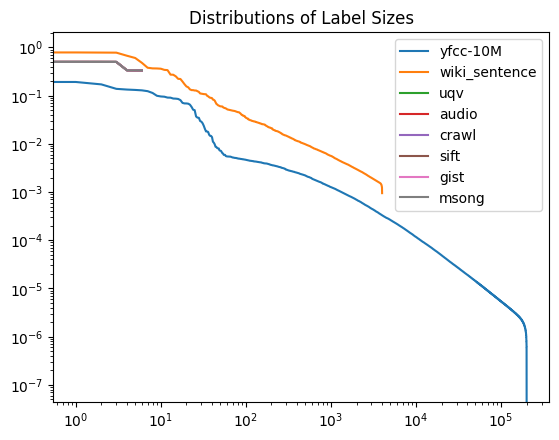

In [24]:
# plot the filter size frequencies on a log scale together as lines
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for name in stats.keys():
    # we sort the filter sizes, then plot the index of the filter size against the filter size
    print(name, stats[name]['size'], stats[name]['n_filters'])
    filter_sizes = np.array(stats[name]['filter_sizes'])
    filter_sizes.sort()
    filter_sizes = filter_sizes / stats[name]['size']
    ax.plot(filter_sizes[::-1], label=name)

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.title("Distributions of Label Sizes")
plt.show()